In [1]:
import numpy as np
from numpy import unravel_index
import nltk
from nltk.stem import PorterStemmer
from nltk.classify import MaxentClassifier
from tqdm import tqdm
import pickle
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

In [2]:
def import_Train_Data():
	ftrain = open("./CRF/assignment2dataset/train.txt")
	lines = ftrain.readlines()

	Sentences = []
	Sentence_Construct = []
	for line in lines:
		if line =='\n':
			Sentences.append(Sentence_Construct)
			Sentence_Construct = []

		else:
			Sentence_Construct.append(line)

	ftrain.close()
	return Sentences


def import_Test_Data():
	ftest = open("./CRF/assignment2dataset/test.txt")
	lines = ftest.readlines()

	Sentences = []
	Sentence_Construct = []
	for line in lines:
		if line =='\n':
			Sentences.append(Sentence_Construct)
			Sentence_Construct = []

		else:
			Sentence_Construct.append(line)

	ftest.close()
	return Sentences


def Remove_Extra_Tag(Sentences):

	Final_Sentences = []

	for line in Sentences:

		##Adding start tag
		Final_Line = []

		for word in line:
			Split_Term = word.split(" ")

			if "-" in Split_Term[2]:
				Final_Word = Split_Term[0]+" "+Split_Term[1]+" "+Split_Term[2].split("-")[0]
				Final_Line.append(Final_Word)

			else:
				Final_Line.append(word[:-1])

		Final_Sentences.append(Final_Line)

	return Final_Sentences

def Get_Tagset(Sentences):

	TagSet = []

	for sentence in Sentences:
		for word in sentence:
			TagSet.append(word.split(" ")[2])

	return set(TagSet)


In [3]:
!unzip CRF.zip

Archive:  CRF.zip
   creating: CRF/
   creating: CRF/assignment2dataset/
  inflating: CRF/assignment2dataset/README  
  inflating: CRF/assignment2dataset/test.txt  
  inflating: CRF/assignment2dataset/train.txt  
  inflating: CRF/conf.png            
  inflating: CRF/CRF-chunking.py     


In [4]:
def build_labelled_features(Sentences):

	####Feature Set being used
	# 3 POS tags -> PrevtopPrev Prev Current 
	# 2 chunk labels -> PrevtoPrev Prev
	# 3  word-stems -> PrevtoPrev Prev Current => Stems
	# Morphological Features -> isCaptital

	labelled_features = []
	
	for sentence in Sentences:

		for word_index in range(0,len(sentence)):

			split_sentence = sentence[word_index].split(" ")

			if word_index == 0:
				# print(sentence[word_index])
				cur_chunk = split_sentence[2]
				prev_to_prev_POS = 'st'
				prev_POS = 'st'
				cur_POS = split_sentence[1]
				prev_to_prev_chunk = 'st'
				prev_chunk = 'st'
				cur_stem = split_sentence[0].lower()
				prev_stem = 'st'
				prev_to_prev_stem = 'st'
				suffix = split_sentence[0].lower().replace(os.path.commonprefix([PorterStemmer().stem(cur_stem), split_sentence[0].lower()]),'')


			elif word_index == 1:
				# print(sentence[word_index])
				prev_split = sentence[word_index-1].split(" ")

				cur_chunk = split_sentence[2]
				prev_to_prev_POS = 'st'
				prev_POS = prev_split[1]
				cur_POS = split_sentence[1]
				prev_to_prev_chunk = 'st'
				prev_chunk = prev_split[2]
				cur_stem = split_sentence[0].lower()
				prev_stem = prev_split[0].lower()
				prev_to_prev_stem = 'st'
				suffix = split_sentence[0].lower().replace(os.path.commonprefix([PorterStemmer().stem(cur_stem), split_sentence[0].lower()]),'')

				
			else:
				prev_split1 = sentence[word_index-1].split(" ")
				prev_split2 = sentence[word_index-2].split(" ")

				cur_chunk = split_sentence[2]
				prev_to_prev_POS = prev_split2[1]
				prev_POS = prev_split1[1]
				cur_POS = split_sentence[1]
				prev_to_prev_chunk = prev_split2[2]
				prev_chunk = prev_split1[2]
				cur_stem = split_sentence[0].lower()
				prev_stem = prev_split1[0].lower()
				prev_to_prev_stem = prev_split2[0].lower()
				suffix = split_sentence[0].lower().replace(os.path.commonprefix([PorterStemmer().stem(cur_stem), split_sentence[0].lower()]),'')


			labelled_item = cur_chunk, prev_to_prev_POS, prev_POS, cur_POS, prev_to_prev_chunk, prev_chunk, cur_stem, prev_stem, prev_to_prev_stem, suffix
			labelled_features.append(labelled_item)

	return labelled_features


In [5]:
Train_Sentences = import_Train_Data()
Test_Sentences = import_Test_Data()

Train_Sentences = Remove_Extra_Tag(Train_Sentences)
Test_Sentences = Remove_Extra_Tag(Test_Sentences)

In [6]:
Set_of_Tags = sorted(list(Get_Tagset(Train_Sentences)))
# Set_of_Tags.append('st')
indextags = {}
# indextags['B']=0
# indextags['I']=1
for tag_ind in range(0,len(Set_of_Tags)):
    indextags[Set_of_Tags[tag_ind]] = tag_ind


In [8]:
indexwords = {}
indexpos = {}
for i in range(len(Train_Sentences)):
    for j in (Train_Sentences[i]):
        
        j = j.split(' ')
        word = j[0]
        tag = j[1]
        # if j[2]=='O':
        #   continue
        if word not in indexwords.keys():
          indexwords[word] = len(indexwords)
        if tag not in indexpos.keys():
          indexpos[tag] = len(indexpos)
indexwords['oov'] = len(indexwords)
indexpos['oov'] = len(indexpos)

In [9]:
indexwords['oov']

19122

In [10]:
indexpos

{'#': 24,
 '$': 26,
 "''": 20,
 '(': 25,
 ')': 27,
 ',': 11,
 '.': 14,
 ':': 39,
 'CC': 12,
 'CD': 18,
 'DT': 2,
 'EX': 22,
 'FW': 40,
 'IN': 1,
 'JJ': 8,
 'JJR': 33,
 'JJS': 30,
 'MD': 23,
 'NN': 0,
 'NNP': 10,
 'NNPS': 28,
 'NNS': 9,
 'PDT': 37,
 'POS': 13,
 'PRP': 29,
 'PRP$': 17,
 'RB': 4,
 'RBR': 32,
 'RBS': 36,
 'RP': 38,
 'SYM': 42,
 'TO': 6,
 'UH': 43,
 'VB': 7,
 'VBD': 21,
 'VBG': 16,
 'VBN': 5,
 'VBP': 15,
 'VBZ': 3,
 'WDT': 34,
 'WP': 31,
 'WP$': 41,
 'WRB': 35,
 '``': 19,
 'oov': 44}

In [11]:
class MyData(torch.utils.data.Dataset):
    def __init__(self, indexwords, indexpos, indextags, dataset_list):
        self.indexwords = indexwords.copy()
        self.indextags = indextags
        self.dataset_list = dataset_list
        self.indexpos = indexpos

    def __getitem__(self, item):

        sent = self.dataset_list[item]
        wid = []
        tagid = []
        pid = []
        for i in sent:
            i = i.split(' ')
            word = i[0]
            tag = i[1]
            # if i[2]=='O':
            #   continue
            if word not in self.indexwords.keys():
                word = 'oov'
            if tag not in self.indexpos.keys():
                tag = 'oov'
            wid.append(self.indexwords[word])
            pid.append(self.indexpos[tag])
            tagid.append(self.indextags[i[2]])
        assert len(wid)==len(tagid)
        # print(len(tagid))
        return torch.LongTensor(wid), torch.LongTensor(pid), torch.LongTensor(tagid)

    def __len__(self):
        return len(self.dataset_list)


In [12]:
gpu = 0
device = torch.device(gpu if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(gpu)
print(device)

cuda:0


In [13]:
BATCH_SIZE = 1

In [14]:
train_set = MyData(indexwords, indexpos, indextags, Train_Sentences)
train_set, val_set = torch.utils.data.random_split(train_set, [int(0.8*len(train_set)), len(train_set)-int(0.8*len(train_set))] )
train_set = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_set = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [15]:
class BiLSTMNet(nn.Module):
  def __init__(self, hidden_dim, num_words, numpostags, n_layers=1, numTags=3):
    super(BiLSTMNet, self).__init__()
    self.hidden_dim = hidden_dim
    self.embeddings = nn.Embedding(num_words, hidden_dim)
    self.embeddings2 = nn.Embedding(numpostags, hidden_dim)
    self.bilstm = nn.LSTM(2*hidden_dim, hidden_dim, n_layers, batch_first=True, bidirectional = True)
    self.fc = nn.Linear(hidden_dim*2,numTags)
    self.dropout = nn.Dropout(0.3)
    self.softmax = nn.Softmax(dim=2)

  def forward(self,x,y):
    x = self.embeddings(x)
    y = self.embeddings2(y)
    x = torch.cat([x,y], dim=-1)
    unpacked, (h_n, c_n) = self.bilstm(x)
    out = self.fc(unpacked)
    out = self.dropout(out)
    return self.softmax(out)

In [26]:
# loss_criteria = nn.BCELoss()
loss_criteria = nn.CrossEntropyLoss()
model = BiLSTMNet(1024, len(indexwords), len(indexpos))
# model = BiLSTMNet(64, len(indexwords))
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
epochs = 10

In [17]:
from sklearn.metrics import accuracy_score

In [27]:
# model.train()

for epoch in range(9):
    total_loss = 0
    train_acc = 0
    count = 0
    model.train()
    for (x,t,y) in train_set:
        # print(x.shape, y.shape)
        optimizer.zero_grad()
        out = model(x.to(device), t.to(device))
        # print(out.shape)
        loss = loss_criteria(out[0], y[0].to(device))
        loss.backward()
        optimizer.step()
        # scheduler.step(loss)
        total_loss += loss.item()
        # print(torch.argmax(out, dim=-1).detach().numpy())
        # print(y)
        train_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
        count+=len(x)
    
    print(f"Training loss for epoch {epoch+1}: {total_loss/count}")
    print(f"Training accuracy for epoch {epoch+1}: {train_acc/count*100}%")
    model.eval()
    total_loss = 0
    val_acc = 0
    count = 0
    for (x,t,y) in val_set:
        
        out = model(x.to(device), t.to(device))
        loss = loss_criteria(out[0], y[0].to(device))
        
        total_loss += loss.item()
        val_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
        count+=len(x)
    
    print(f"Validation loss for epoch {epoch+1}: {total_loss/count}")
    print(f"Validation accuracy for epoch {epoch+1}: {val_acc/count*100}%")
    print('='*20)
    # model.eval()
    # total_loss = 0
    # test_acc = 0
    # count = 0
    # preds = []
    # gold = []
    # for (x,t,y) in test_set:
    #     out = model(x.to(device), t.to(device))
    #     loss = loss_criteria(out[0], y[0].to(device))
        
    #     total_loss += loss.item()
    #     gold.extend(y[0].detach().cpu().numpy())
    #     preds.extend(torch.argmax(out, dim=-1).detach().cpu().numpy()[0])
    #     test_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
    #     count+=len(x)

    # print(f"Test loss : {total_loss/count}")
    # print(f"Test accuracy : {test_acc/count*100}%")

Training loss for epoch 1: 0.7049368742246767
Training accuracy for epoch 1: 83.59017349486373%
Validation loss for epoch 1: 0.6072558696304658
Validation accuracy for epoch 1: 94.63920286978535%
Training loss for epoch 2: 0.661971025740093
Training accuracy for epoch 2: 86.78517225892219%
Validation loss for epoch 2: 0.5986015070271439
Validation accuracy for epoch 2: 95.37839250249178%
Training loss for epoch 3: 0.6553856484804597
Training accuracy for epoch 3: 87.22129202854163%
Validation loss for epoch 3: 0.5953997047222167
Validation accuracy for epoch 3: 95.66668323837446%
Training loss for epoch 4: 0.6510208990564543
Training accuracy for epoch 4: 87.69841270585216%
Validation loss for epoch 4: 0.5929585738603435
Validation accuracy for epoch 4: 95.85183498470133%
Training loss for epoch 5: 0.6483235623860533
Training accuracy for epoch 5: 87.89345124070506%
Validation loss for epoch 5: 0.5931554479353647
Validation accuracy for epoch 5: 95.83164610279127%
Training loss for epo

In [19]:
test_set = MyData(indexwords, indexpos, indextags, Test_Sentences)
test_set = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)


In [28]:
model.eval()
total_loss = 0
test_acc = 0
count = 0
preds = []
gold = []
for (x,t,y) in test_set:
    out = model(x.to(device), t.to(device))
    loss = loss_criteria(out[0], y[0].to(device))
    
    total_loss += loss.item()
    gold.extend(y[0].detach().cpu().numpy())
    preds.extend(torch.argmax(out, dim=-1).detach().cpu().numpy()[0])
    test_acc += accuracy_score(y[0].detach().cpu().numpy(),torch.argmax(out, dim=-1).detach().cpu().numpy()[0])*len(x)
    count+=len(x)

print(f"Test loss : {total_loss/count}")
print(f"Test accuracy : {test_acc/count*100}%")

Test loss : 0.5892829192917105
Test accuracy : 96.16986840423894%


In [29]:
print(accuracy_score(gold,preds))

0.961690271650801


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(gold,preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     23852
           1       0.96      0.95      0.95     17345
           2       0.97      0.95      0.96      6180

    accuracy                           0.96     47377
   macro avg       0.96      0.96      0.96     47377
weighted avg       0.96      0.96      0.96     47377



In [32]:
indextags

{'B': 0, 'I': 1, 'O': 2}

[[23281   527    44]
 [  801 16406   138]
 [  105   200  5875]]


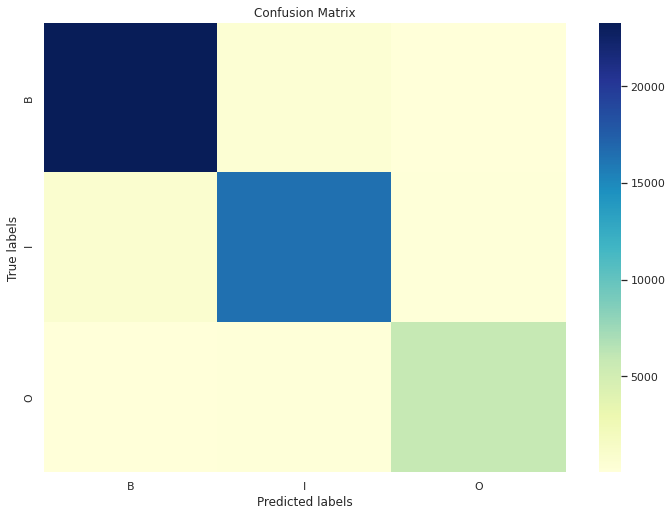

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt  

cm = confusion_matrix(gold, preds, list(indextags.values()))
print(cm)

sns.set(rc={'figure.figsize':(11.7,8.27)})


ax= plt.subplot()
sns.heatmap(cm, annot=False, ax = ax,cmap="YlGnBu")

ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(list(indextags.keys()))
ax.yaxis.set_ticklabels(list(indextags.keys()));
plt.show()


Error analysis

In [ ]:
model.eval()
total_loss = 0
test_acc = 0
count = 0
preds = []
gold = []
for (x,t,y) in test_set:
    count+=1
    out = model(x.to(device), t.to(device))
    loss = loss_criteria(out[0], y[0].to(device))
    
    total_loss += loss.item()
    g = y[0].detach().cpu().numpy()
    p = torch.argmax(out, dim=-1).detach().cpu().numpy()[0]
    if accuracy_score(g,p)!=1:
      print( [list(indexwords.keys())[list(indexwords.values()).index(j)] for j in x.detach().cpu().numpy()[0] ])
      print([list(indexpos.keys())[list(indexpos.values()).index(j)] for j in t.detach().cpu().numpy()[0] ])
      print( [list(indextags.keys())[list(indextags.values()).index(j)] for j in p])
      print( [list(indextags.keys())[list(indextags.values()).index(j)] for j in g])
      print('='*20)
    if count>100:
      break

['oov', 'oov', ',', 'general', 'manager', 'of', 'the', 'stock', 'trading', 'division', 'at', 'Nikko', 'Securities', ',', 'said', 'that', 'after', 'looking', 'at', 'the', 'reasons', 'for', 'Friday', "'s", 'Wall', 'Street', 'plunge', ',', 'participants', 'realized', 'that', 'the', 'Tokyo', 'and', 'New', 'York', 'markets', 'have', 'different', 'economic', 'fundamentals', '.']
['NNP', 'NNP', ',', 'JJ', 'NN', 'IN', 'DT', 'NN', 'NN', 'NN', 'IN', 'NNP', 'NNP', ',', 'VBD', 'IN', 'IN', 'VBG', 'IN', 'DT', 'NNS', 'IN', 'NNP', 'POS', 'NNP', 'NNP', 'NN', ',', 'NNS', 'VBD', 'IN', 'DT', 'NNP', 'CC', 'NNP', 'NNP', 'NNS', 'VBP', 'JJ', 'JJ', 'NNS', '.']
['B', 'I', 'O', 'B', 'I', 'B', 'B', 'I', 'I', 'I', 'B', 'B', 'I', 'O', 'B', 'B', 'B', 'B', 'B', 'B', 'I', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'B', 'B', 'B', 'B', 'I', 'O', 'B', 'I', 'I', 'B', 'B', 'I', 'I', 'O']
['B', 'I', 'O', 'B', 'I', 'B', 'B', 'I', 'I', 'I', 'B', 'B', 'I', 'O', 'B', 'B', 'B', 'B', 'B', 'B', 'I', 'B', 'B', 'B', 'I', 'I', 'I', 'O', 'B',

In [ ]:
print(model)

BiLSTMNet(
  (embeddings): Embedding(8119, 1024)
  (embeddings2): Embedding(44, 1024)
  (bilstm): LSTM(2048, 1024, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=2048, out_features=3, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (softmax): Softmax(dim=2)
)
